In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # another visualization library, does correlation matrix

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA # dimensionality reduction
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, GridSearchCV

import pydotplus # to print the tree
from IPython.display import Image

import keras
from keras import metrics
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

In [19]:
import warnings
warnings.filterwarnings("ignore")

# Data

###  Run 1st when generating df_nonames, or to RESET (load original file)

In [3]:
df = pd.read_csv("NewYork_Airbnb.csv") # imports the data frame (I renamed it NewYork_Airbnb.csv)
# original title was AB_NYC_2019.csv, but I changed the name to make it more comprehensive
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
df.info() # see data types, and total number of non-null values
        # (ideally, each number under "Non-Null Count" should be 48895)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [30]:
df.describe() # gives ranges of values

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [4]:
df.isna().sum() # number of null values in each feature

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

# Visualization

### Run 2nd when generating df_nonames (data cleaning)

In [6]:
# Drop useless columns (Airbnb name and ID, host name and ID, date of last review)
df_nonames = df.drop(["id", "name", "host_id", "host_name", "last_review"], axis = 1)

# Fill in missing reviews-per-month values with the mean of the non-missing values from the same column
df_nonames["reviews_per_month"] = df_nonames["reviews_per_month"].fillna(np.mean(df_nonames["reviews_per_month"]))
df_nonames.dropna(inplace = True) # inplace so you don't have to declare a new variable

df_nonames.head() # now how does it look?

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.210000,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.380000,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1.373221,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.640000,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.100000,1,0


In [7]:
df_nonames.isna().sum() # no missing values after dropping some columns and imputing values in another!

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [8]:
df_nonames.shape # still have all the instances

(48895, 11)

## Plotting longitude vs price

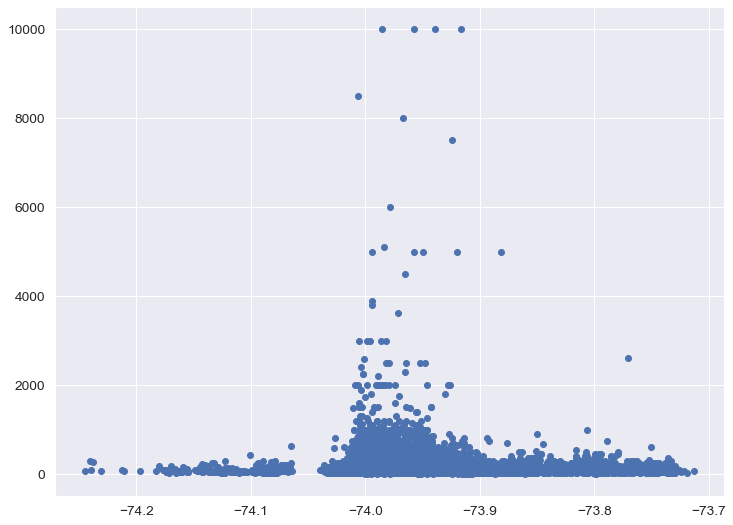

In [9]:
fig, ax = plt.subplots(figsize = (12, 9)) # creates a plot of dimensions 12, 9
plt.scatter(df_num["longitude"], df_num["price"])

### So, the most expensive Airbnbs are between longitude -73.9 and -74.0!

# Correlation Matrix

## Run this cell to get df_num (df_nonames, but with only the numerical features)

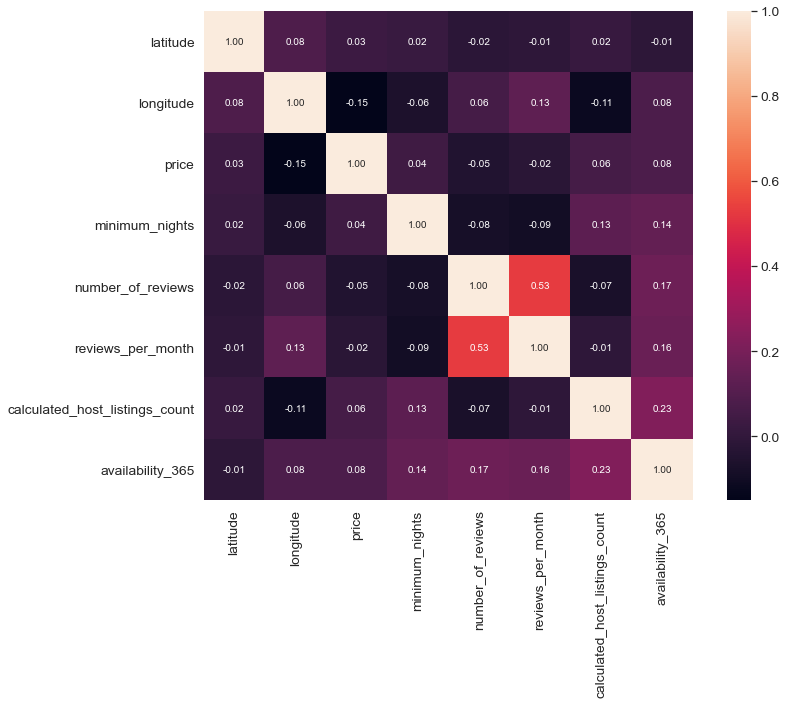

In [9]:
# correlation matrix; will tell us how each variable is related to each other
# I will focus on how each variable is related to our target (price)

df_num = df_nonames.select_dtypes(include = np.number) # only selects numerical columns
fig, ax = plt.subplots(figsize = (12, 9)) # creates a plot of dimensions 12, 9
sns.set(font_scale = 1.25) # set dimension for text
coef = np.corrcoef(df_num.values.T) # calculate correlation coefficient
cols = df_num.columns

plt.clf()
sns.heatmap(coef, square = True, cbar = True, annot = True,
            fmt = ".2f", annot_kws = {"size":10},
            xticklabels = cols.values, yticklabels = cols.values)
# funky formatting, fmt ensures 2 decimal places
plt.savefig("NYCAirbnbCorrMatrix.pdf")

## Correlation Matrix but with no prices above 1000 (just to check)

<AxesSubplot:>

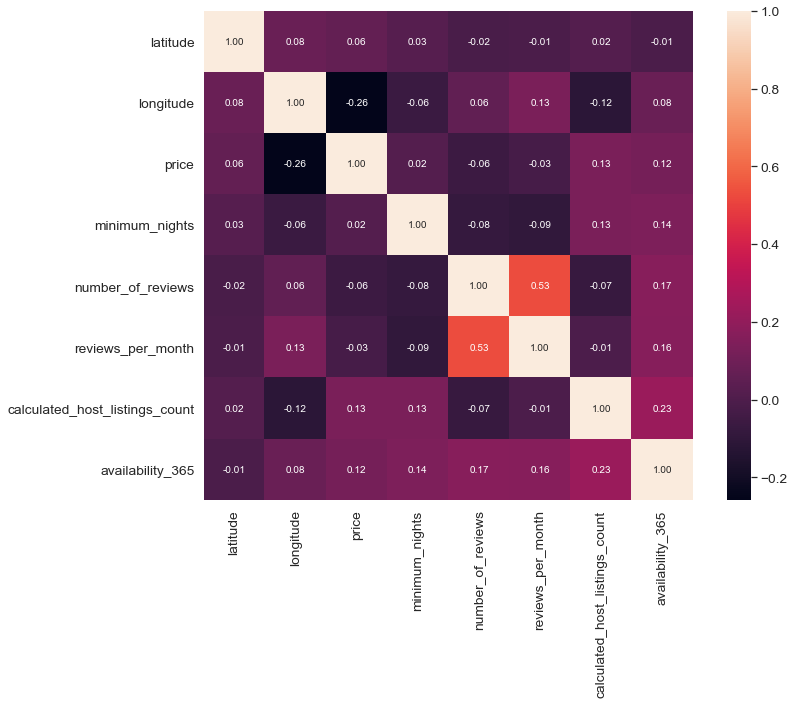

In [10]:
# correlation matrix; will tell us how each variable is related to each other
# will focus on how each variable is related to our target (price)
df_under1000 = df_nonames[df_nonames["price"] <= 1000]
df_num = df_under1000.select_dtypes(include = np.number) # only selects numerical columns
fig, ax = plt.subplots(figsize = (12, 9)) # creates a plot of dimensions 12, 9
sns.set(font_scale = 1.25) # set dimension for text
coef = np.corrcoef(df_num.values.T) # calculate correlation coefficient
cols = df_num.columns

sns.heatmap(coef, square = True, cbar = True, annot = True,
            fmt = ".2f", annot_kws = {"size":10},
            xticklabels = cols.values, yticklabels = cols.values)
# funky formatting, 2 decimal places

# Feature Importance (need df_num, the data frame with only numerical features!)

Feature ranking:
1. feature 1 (0.333108)
2. feature 0 (0.247166)
3. feature 6 (0.127562)
4. feature 4 (0.080987)
5. feature 3 (0.074399)
6. feature 2 (0.072785)
7. feature 5 (0.063994)


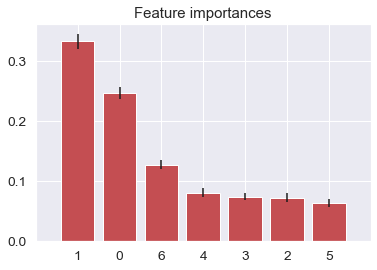

In [11]:
# random forest
# should immediately get best attributes for predicting price
import numpy as np
import matplotlib.pyplot as plt

# Split data
X = np.array(df_num[["latitude", "longitude", "minimum_nights", "number_of_reviews", "reviews_per_month",
            "calculated_host_listings_count", "availability_365"]])
y = np.array(df_num["price"])


# Build a forest and compute the impurity-based feature importances
forest = RandomForestRegressor(n_estimators=150, max_depth = 16, random_state=0)

forest.fit(X, y)

importances = forest.feature_importances_ # Rank features in X in order of importance for determining y (price)
# feature 0 = latitude
# feature 1 = longitude
# feature 2 = minimum_nights
# feature 3 = number_of_reviews
# feature 4 = reviews_per_month
# feature 5 = calculated_host_listings_count
# feature 6 = availability_365

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# Source: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

### Longitude appears to be most predictive!

## Feature importance, but only using Airbnbs under $1000

In [70]:
df_num_under1k = df_num[df_num["price"] <= 1000]
# data frame with only numerical vars, and prices $1000 and less

Feature ranking:
1. feature 1 (0.333108)
2. feature 0 (0.247166)
3. feature 6 (0.127562)
4. feature 4 (0.080987)
5. feature 3 (0.074399)
6. feature 2 (0.072785)
7. feature 5 (0.063994)


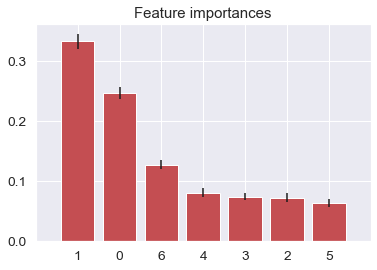

In [71]:
# Split data
X = np.array(df_num_under1k[["latitude", "longitude", "minimum_nights", "number_of_reviews", "reviews_per_month",
            "calculated_host_listings_count", "availability_365"]])
y = np.array(df_num_under1k["price"])


# Build a forest and compute the impurity-based feature importances
forest = RandomForestRegressor(n_estimators=150, max_depth = 16, random_state=0)

forest.fit(X, y)

importances = forest.feature_importances_ # Rank features in X in order of importance for determining y (price)
# feature 0 = latitude
# feature 1 = longitude
# feature 2 = minimum_nights
# feature 3 = number_of_reviews
# feature 4 = reviews_per_month
# feature 5 = calculated_host_listings_count
# feature 6 = availability_365

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

### Longitude appears to be most predictive again!

## Neighborhoods without extreme outliers (Airbnbs $1000 and under)

<AxesSubplot:xlabel='neighbourhood_group', ylabel='price'>

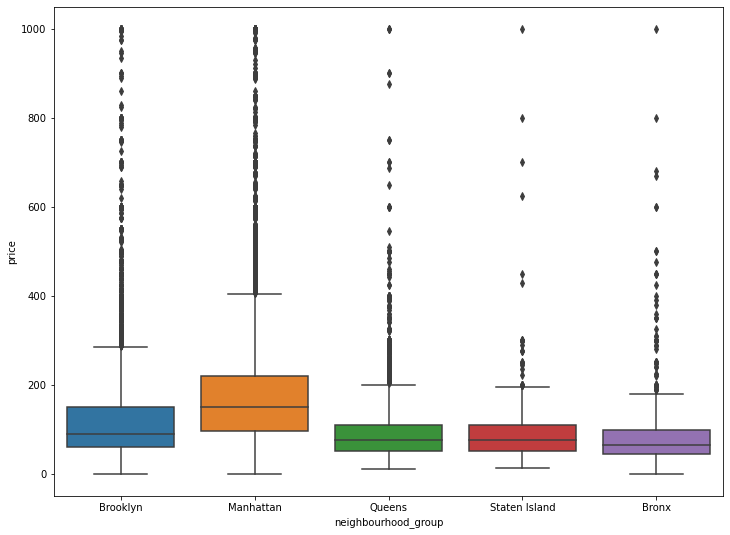

In [5]:
fig, ax = plt.subplots(figsize = (12, 9)) # creates a plot of dimensions 12, 9
df_nooutliers = df_nonames[df_nonames["price"] <= 1000]
sns.boxplot(x = "neighbourhood_group", y = "price", data = df_nooutliers, ax = ax)

## Neighborhoods with extreme outliers

<AxesSubplot:xlabel='neighbourhood_group', ylabel='price'>

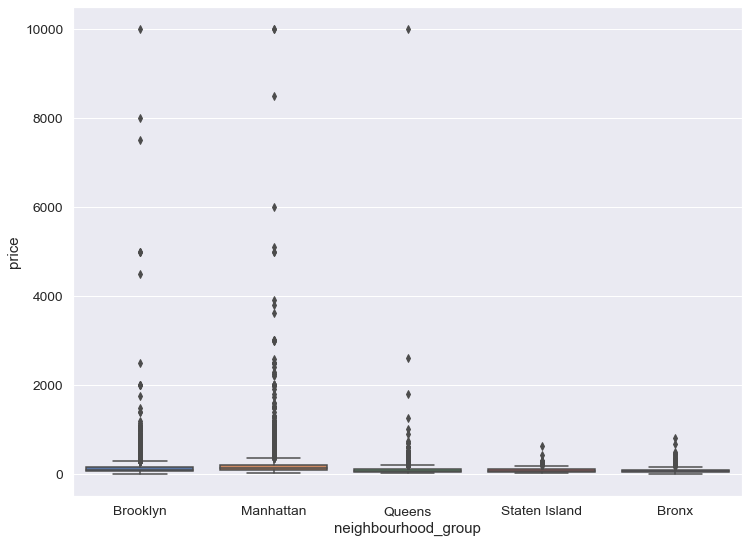

In [26]:
fig, ax = plt.subplots(figsize = (12, 9)) # creates a plot of dimensions 12, 9
sns.boxplot(x = "neighbourhood_group", y = "price", data = df_nonames, ax = ax)

## Room type without extreme outliers (Airbnbs $1000 and under)

<AxesSubplot:xlabel='room_type', ylabel='price'>

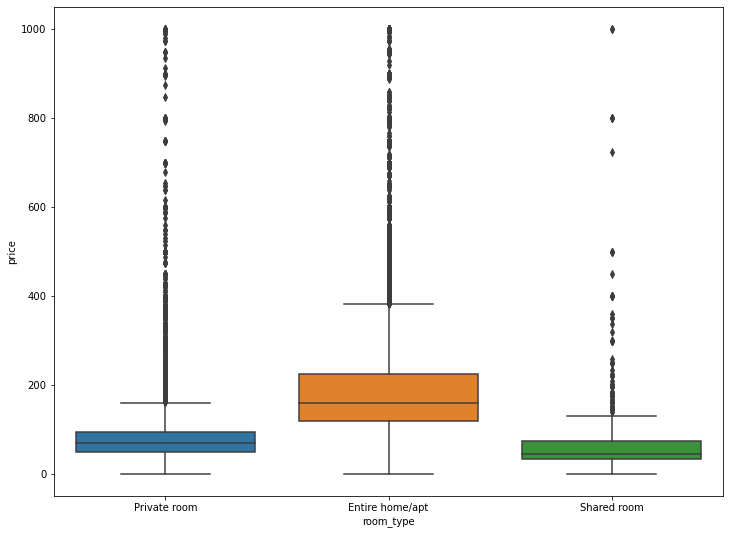

In [6]:
fig, ax = plt.subplots(figsize = (12, 9)) # creates a plot of dimensions 12, 9
df_nooutliers = df_nonames[df_nonames["price"] <= 1000]
sns.boxplot(x = "room_type", y = "price", data = df_nooutliers, ax = ax)

## Room type with extreme outliers

<AxesSubplot:xlabel='room_type', ylabel='price'>

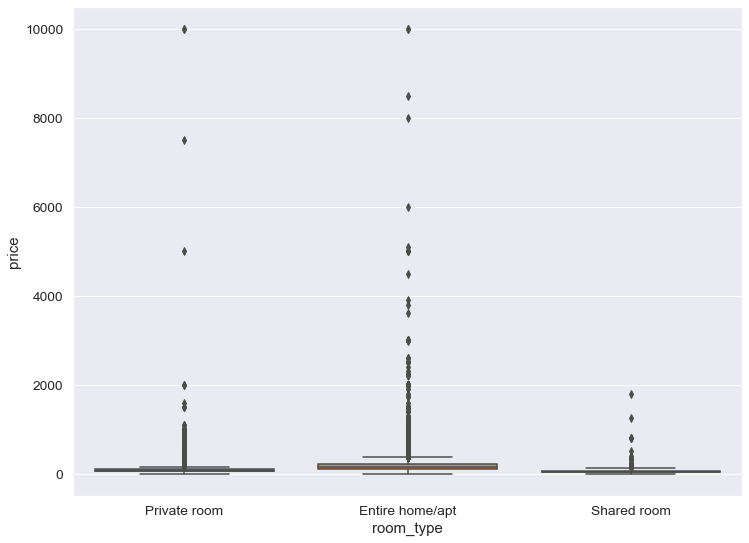

In [27]:
fig, ax = plt.subplots(figsize = (12, 9)) # creates a plot of dimensions 12, 9
sns.boxplot(x = "room_type", y = "price", data = df_nonames, ax = ax)

# Examining the prices more closely

In [29]:
print("Maximum Airbnb price in New York is", max(df_nonames["price"]))
print("Minimum Airbnb price in New York is", min(df_nonames["price"]))
# Wait... FREE Airbnbs???
# No can do. We'll be removing those free Airbnbs... and the ones over $1000 (to improve model).

Maximum Airbnb price in New York is 10000
Minimum Airbnb price in New York is 0


In [32]:
print("There are", sum(df_nonames["price"] == 0), "free Airbnbs")
print("There are", sum(df_nonames["price"] > 1000), "Airbnbs over $1000/night")

There are 11 free Airbnbs
There are 239 Airbnbs over $1000/night


## Oh, look, there are free (not in reality) Airbnbs in this dataset! Remove them; the $0 price can't be right.

# Now, let's restrict the price range to \\$1000 and less, and exclude those $0 Airbnbs

## set/reset df_under1k (RUN 1ST BEFORE SWITCHING SCALING METHODS!)

In [35]:
df_under1k = df_nonames[(df_nonames["price"] <= 1000) & (df_nonames["price"] != 0)]
# df_under1k

In [13]:
print("Minimum price in new abridged data set is", min(df_under1k["price"]))
print("Maximum price in new abridged data set is", max(df_under1k["price"]))

Minimum price in new abridged data set is 10
Maximum price in new abridged data set is 1000


# One-Hot Encoding

### Get df_under1k before running this cell!
### Also, run this cell 2nd before switching scaling methods.

In [36]:
# apply one-hot encoder to categorical features, with dummies
dummies_ngroup = pd.get_dummies(df_under1k["neighbourhood_group"], prefix = "n_group")
dummies_n = pd.get_dummies(df_under1k["neighbourhood"], prefix = "neighborhood")
dummies_room = pd.get_dummies(df_under1k["room_type"], prefix = "room_type")
df_under1k.drop(["neighbourhood_group", "neighbourhood", "room_type"], axis = 1, inplace = True)

frames = [dummies_ngroup, dummies_n, dummies_room, df_under1k]
df_oh = pd.concat(frames, axis = 1) # one-hot encoded data frame
# df_oh

# this is now being done with df_under1k, originally done with df_nonames

## Min-Max Scaler AND Splitting! (reusable code, obtain df_oh first)

In [18]:
y = df_oh["price"]
X_beforescaling = df_oh.drop(["price"], axis = 1 )
scaler = MinMaxScaler()
X = scaler.fit_transform(X_beforescaling)


# Split data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [11]:
df_oh # print the one hot encoded dataset

,n_group_Bronx,n_group_Brooklyn,n_group_Manhattan,n_group_Queens,n_group_Staten Island,neighborhood_Allerton,neighborhood_Arden Heights,neighborhood_Arrochar,neighborhood_Arverne,neighborhood_Astoria,...,room_type_Private room,room_type_Shared room,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,0,1,0,0,0,0,0,0,0,0,...,1,0,40.64749,-73.97237,149.0,1.0,9.0,0.210000,6.0,365.0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,40.75362,-73.98377,225.0,1.0,45.0,0.380000,2.0,355.0
2,0,0,1,0,0,0,0,0,0,0,...,1,0,40.80902,-73.94190,150.0,3.0,0.0,1.373221,1.0,365.0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,40.68514,-73.95976,89.0,1.0,270.0,4.640000,1.0,194.0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,40.79851,-73.94399,80.0,10.0,9.0,0.100000,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,0,1,0,0,0,0,0,0,0,0,...,1,0,40.67853,-73.94995,70.0,2.0,0.0,1.373221,2.0,9.0
48891,0,1,0,0,0,0,0,0,0,0,...,1,0,40.70184,-73.93317,40.0,4.0,0.0,1.373221,2.0,36.0
48892,0,0,1,0,0,0,0,0,0,0,...,0,0,40.81475,-73.94867,115.0,10.0,0.0,1.373221,1.0,27.0
48893,0,0,1,0,0,0,0,0,0,0,...,0,1,40.75751,-73.99112,55.0,1.0,0.0,1.373221,6.0,2.0


## Standard Scaler AND Splitting! (reusable code, obtain df_oh first)

In [21]:
y = df_oh["price"]
X_beforescaling = df_oh.drop(["price"], axis = 1 )
scaler = StandardScaler()
X = scaler.fit_transform(X_beforescaling)

# Split data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(X_test.shape)

# I'm outputting the dimensions here, because the input_dim hyperparameter of a FNN
# depends on what the value of the second dimension (columns) is (it changes based on
# the version of the data you give it)

(36483, 236)
(12162, 236)


# Random Forest Regressor (data needs to be scaled and split first)

In [22]:
# Random forest
rfr = RandomForestRegressor() # default 100 trees
rfr = rfr.fit(X_train, y_train)

## Let's collect 3 error metrics: mean absolute error, root mean squared error, and explained variance score. You'll see the results written in comments in the following cells.

In [23]:
predictions = rfr.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mae

# Random Forest results:
# mae = 63.80905200152704 with df_nonames (min-max scaling)
# mae = 64.0484283649651 with df_nonames (standard scaling)... very little difference
# mae = 49.51092501233351 with df_under1k (min-max scaling)
# mae = 49.66691813298252 with df_under1k (standard scaling)... virtually no difference
# mae = 40.57083026755853 with df_under500 (standard scaling)

In [24]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))
rmse

# Random Forest results:
# rmse = 190.3 with df_nonames (min-max scaling)
# rmse = 191.6 with df_nonames (standard scaling)
# rmse = 88.1 with df_under1k (min-max scaling)
# rmse = 88.2 with df_under1k (standard scaling)... virtually no difference
# rmse = 61.2 with df_under500 (standard scaling)

# We do scaling because different features have different ranges of values
# Scaling normalizes the ranges of features to a universal range/scale

# Different scaling formulas found here: https://www.geeksforgeeks.org/ml-feature-scaling-part-2/ 

In [25]:
y_test # the correct answers (just an example)

1947      99
42543    225
15187    268
25988     47
29333    250
        ... 
3813     900
5014      70
431      165
38733    307
42015     45
Name: price, Length: 12162, dtype: int64

In [26]:
predictions # the model's predictions (just an example)

array([182.76, 253.36, 289.89, ..., 211.59, 264.36,  63.13])

In [29]:
explained_variance_score(y_test, predictions)
# score was 0.13 with df_nonames (min-max scaling)
# score was 0.12 with df_nonames (standard scaling)
# score was 0.45 with df_under1k (min-max scaling)
# score was 0.45 with df_under1k (standard scaling)
# score then became 0.52 with df_under500 (standard scaling)

## As you could see by the results, the error metrics did not change much between standard scaling and min-max scaling. So we will be sticking with standard scaling from this point on.

# Lasso Regression

## the purpose is to add penalties for over/underfitting the data

### once again, collect error metrics

In [31]:
lr = Lasso()
lr = lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("MAE =", mae)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE =", rmse)

print("Explained variance score =", explained_variance_score(y_test, y_pred))

# MAE = 54.8
# RMSE = 95.9
# explained variance score was 0.353 with df_under1k

# explained variance score was 0.446 with df_under500

# Ridge Regression

### once again, collect error metrics

In [32]:
rr = Ridge()
rr = rr.fit(X_train, y_train)
y_pred = rr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("MAE =", mae)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE =", rmse)

print("Explained variance score =", explained_variance_score(y_test, y_pred))

# MAE = 54.9
# RMSE = 95.4
# explained variance score was 0.360 with df_under1k

# explained variance score was 0.455 with df_under500

# What could possibly be causing the overfitting??

(array([4.2669e+04, 4.9910e+03, 6.8200e+02, 2.5500e+02, 1.0600e+02,
        2.7000e+01, 4.0000e+01, 1.5000e+01, 2.8000e+01, 5.0000e+00,
        1.6000e+01, 8.0000e+00, 1.0000e+01, 0.0000e+00, 4.0000e+00,
        4.0000e+00, 7.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        7.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        1.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        3.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([    0.,   250.,   500.,   750.,  1000.,  1250.,  1500.,  1750.,
         2000.,  2250.,  2500.,  2750.,  3000.,  3250.,  3500.,  3750.,
         4000.,  4250.,  4500.,  4750.,  5000.,  5250.,  5500.,  5750.,
         6000.,  6250.,  6500.,  6750.,  7000.,  7250.,  7500.,  7750.,
         8000.,  8250.,  8500.,  8750.,  9000.,  9250.,  9500.,  9750.,
        10000.]),
 <BarContainer object of 40 artists>)

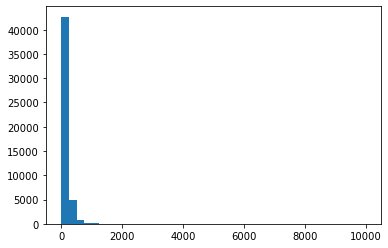

In [5]:
plt.hist(x = df_nonames["price"], bins = 40) # very skewed prices

(array([24557., 16059.,  4958.,  1552.,   716.,   264.,   189.,   169.,
           67.,   114.]),
 array([  10.,  109.,  208.,  307.,  406.,  505.,  604.,  703.,  802.,
         901., 1000.]),
 <BarContainer object of 10 artists>)

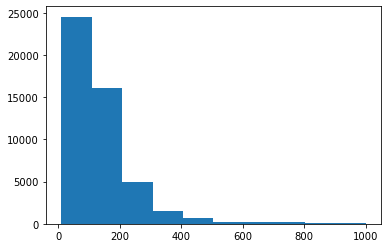

In [6]:
# There are 59 Airbnbs priced at $1000. That's out of 48,645 non-free Airbnbs $1000 and under.
# When we reduce the price ceiling to $500, we are still left with 47,840 rows.

# Let's visualize the Airbnbs under $1000, with x = price and y = frequency

plt.hist(x = df_under1k["price"]) # still pretty skewed

# This cell gets you df_under500 (restricts the price range to $500 and under)

In [33]:
# Histogram with $500 and less
df_under500 = df_nonames[(df_nonames["price"] <= 500) & (df_nonames["price"] != 0)]
df_under500

(array([ 8297., 16206.,  9761.,  6325.,  3109.,  1844.,   890.,   689.,
          323.,   396.]),
 array([ 10.,  59., 108., 157., 206., 255., 304., 353., 402., 451., 500.]),
 <BarContainer object of 10 artists>)

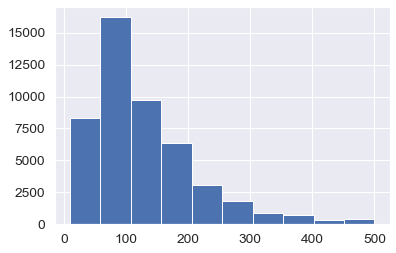

In [101]:
# Next we'll visualize the Airbnbs under $500
plt.hist(x = df_under500["price"]) # doesn't this look better already?

In [4]:
df_nonames["price"].quantile(0.95) # the answer is quite shocking!
# Despite the range of prices being $0 to $10000, the 95th percentile is only $355!

355.0

# So, we should probably focus on just the Airbnbs 500 and under?
## That might be a good idea because most Airbnbs really are priced between 50 and 100.
## Also, we'd only be removing 2.2% of the data--not too much.

Feature ranking:
1. feature 1 (0.355585)
2. feature 0 (0.253436)
3. feature 6 (0.107797)
4. feature 4 (0.078740)
5. feature 3 (0.071200)
6. feature 2 (0.067178)
7. feature 5 (0.066063)


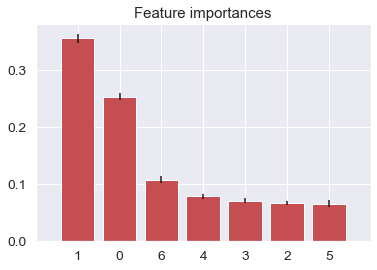

In [110]:
# Let's do a feature importance on $500 and less
# Split data
X = np.array(df_under500[["latitude", "longitude", "minimum_nights", "number_of_reviews", "reviews_per_month",
            "calculated_host_listings_count", "availability_365"]])
y = np.array(df_under500["price"])


# Build a forest and compute the impurity-based feature importances
forest = RandomForestRegressor(n_estimators=150, max_depth = 16, random_state=0)

forest.fit(X, y)

importances = forest.feature_importances_ # Rank features in X in order of importance for determining y (price)
# feature 0 = latitude
# feature 1 = longitude
# feature 2 = minimum_nights
# feature 3 = number_of_reviews
# feature 4 = reviews_per_month
# feature 5 = calculated_host_listings_count
# feature 6 = availability_365

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# Dimensionality reduction

In [112]:
df_under500

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.210000,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.380000,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1.373221,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.640000,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.100000,1,0
...,...,...,...,...,...,...,...,...,...,...,...
48890,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,1.373221,2,9
48891,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,1.373221,2,36
48892,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,1.373221,1,27
48893,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,1.373221,6,2


### one-hot encoding df_under500

In [37]:
# WE NEED TO ONE-HOT ENCODE FIRST

# apply one-hot encoder to categorical features, with dummies
dummies_ngroup = pd.get_dummies(df_under500["neighbourhood_group"], prefix = "n_group")
dummies_n = pd.get_dummies(df_under500["neighbourhood"], prefix = "neighborhood")
dummies_room = pd.get_dummies(df_under500["room_type"], prefix = "room_type")
df_under500.drop(["neighbourhood_group", "neighbourhood", "room_type"], axis = 1, inplace = True)

frames = [dummies_ngroup, dummies_n, dummies_room, df_under500]
df_oh = pd.concat(frames, axis = 1) # one-hot encoded data frame
# df_oh

### start here if you want to change the number of components

In [38]:
# Now, for the real dimensionality reduction.
y = df_oh["price"] # start with the one-hot encoded data set, but not scaled yet.
X_beforescaling = df_oh.drop(["price"], axis = 1 ) # drop the price
scaler = StandardScaler() # scale everything else
X_beforereduction = scaler.fit_transform(X_beforescaling) # notice the different variable name on the left

pca = PCA(n_components = 15) # you can change the number of components here

# eigenvalue transformation is used by the computer to decide which attributes to group together
pca.fit(np.array(X_beforereduction))
X = pca.transform(X_beforereduction)
# and then you split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42 )

In [39]:
X.shape # view the transformed NumPy array

(47840, 15)

## Random forest regressor on Airbnbs $500 and under (after reducing to components)

In [40]:
# Random forest
rfr = RandomForestRegressor()
rfr = rfr.fit(X_train, y_train) # need to get X_train and y_train from directly above first

In [41]:
predictions = rfr.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mae

# Previous random forest regressor results
# mae = 63.80905200152704 with df_nonames
# mae = 49.51092501233351 with df_under1k (min-max scaling)
# mae = 49.66691813298252 with df_under1k (standard scaling)... virtually no difference
# mae = 40.57083026755853 with df_under500 (standard scaling)

# NOW...
# mae = 45.167551003344485 with df_under500 after dimensionality reduction (3 components) with Standard Scaling
# mae = 43.44568060200669 with df_under500 after dimensionality reduction (5 components) with Standard Scaling
# mae = 42.7306906354515 with df_under500 after dimensionality reduction (10 components) with Standard Scaling
# mae = 42.269452341137125 with df_under500 after dimensionality reduction (15 components) with Standard Scaling
# mae = 42.428615384615384 with df_under500 after dimensionality reduction (30 components) with Standard Scaling
# mae = 42.49358193979933 with df_under500 after dimensionality reduction (50 components) with Standard Scaling

In [42]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))
rmse

# Previous random forest regressor results
# rmse ~ 190 with df_nonames
# rmse = 88.1 with df_under1k (min-max scaling)
# rmse = 88.2 with df_under1k (standard scaling)... virtually no difference
# rmse = 61.2 with df_under500 (standard scaling)

# NOW...
# rmse = 67.3 with df_under500 after dimensionality reduction (3 components) with Standard Scaling
# rmse = 65.1 with df_under500 after dimensionality reduction (5 components) with Standard Scaling
# rmse = 64.3 with df_under500 after dimensionality reduction (10 components) with Standard Scaling
# rmse = 63.6 with df_under500 after dimensionality reduction (15 components) with Standard Scaling
# rmse = 63.77541466101139 with df_under500 after dimensionality reduction (15 components) with Standard Scaling
# rmse = 63.8 with df_under500 after dimensionality reduction (50 components) with Standard Scaling

In [45]:
np.array(y_test) # the correct answers (just an example)

array([ 60,  55, 250, ...,  75,  69, 160])

In [44]:
predictions # the model's predictions (just an example)

array([ 54.69,  57.19, 301.7 , ...,  46.  , 117.54, 139.34])

In [46]:
explained_variance_score(y_test, predictions)
# Previous random forest regressor results
# score was 0.13 with df_nonames
# score is now 0.45 with df_under1k
# score then became 0.52 with df_under500

# NOW...
# score is 0.42 with df_under500 after dimensionality reduction (3 components) with Standard Scaling
# score is 0.46 with df_under500 after dimensionality reduction (5 components) with Standard Scaling
# score is 0.47 with df_under500 after dimensionality reduction (10 components) with Standard Scaling
# score is 0.482 with df_under500 after dimensionality reduction (15 components) with Standard Scaling
# score is 0.480 with df_under500 after dimensionality reduction (15 components) with Standard Scaling
# score is 0.479 with df_under500 after dimensionality reduction (50 components) with Standard Scaling

## Lasso regression on Airbnbs $500 and under (after reducing to components)

In [47]:
lr = Lasso()
lr = lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("MAE =", mae)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE =", rmse)

print("Explained variance score =", explained_variance_score(y_test, y_pred))

# Standard-scaling + lasso regression with prices <= $1000
# MAE = 54.8
# RMSE = 95.9
# explained variance score was 0.353 with df_under1k (standard scaling)

# Standard-scaling + lasso regression with prices <= $500
# MAE = 44.30230840437801
# RMSE = 65.80452529740188
# explained variance score was 0.446 with df_under500 (standard scaling)

# Dimensionality reduction + lasso regression with prices <= $500
# MAE = 46.223910765630144
# RMSE = 68.22820653734261
# Explained variance score = 0.4043532446506043 with df_under500 (dim red with 15 components)

## Ridge regression on Airbnbs $500 and under (after reducing to components)

In [48]:
rr = Ridge()
rr = rr.fit(X_train, y_train)
y_pred = rr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("MAE =", mae)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE =", rmse)

print("Explained variance score =", explained_variance_score(y_test, y_pred))

# Standard-scaling + ridge regression with prices <= $1000
# MAE = 54.9
# RMSE = 95.4
# explained variance score was 0.360 with df_under1k (standard scaling)

# Standard-scaling + ridge regression with prices <= $500
# MAE = 44.08836153781015
# RMSE = 65.23845812077376
# explained variance score was 0.455 with df_under500 (standard scaling)

# Dimensionality reduction + ridge regression with prices <= $500
# MAE = 46.20393453985867
# RMSE = 68.19122327612949
# Explained variance score = 0.40499226214356787 with df_under500 (dim-red with 15 components)

# Support Vector Regression (after reducing to components)

In [49]:
svr = SVR()
svr = svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("MAE =", mae)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE =", rmse)

print("Explained variance score =", explained_variance_score(y_test, y_pred))

# After dimensionality reduction...
# MAE = 42.59
# RMSE = 69.16
# Explained variance score = 0.425

# Feedforward Network

## construct the FNN here

In [53]:
def add_layers():
    reg = Sequential()
    reg.add( Dense(units = 32, kernel_initializer = "uniform", activation = "relu", input_dim = 234) )
    # adds a layer to the neural network
    # layers of size 32
    # ReLu (Rectified Linear Unit) acts like neurons, outputting values at full potential
    # the one-hot encoded df_under500 has 235 columns!
    
#     reg.add(Dropout(0.1)) # randomly drop 10% of the data
    # Dropout is used for regularization, to ensure the model doesn't overfit, or over-learn
    
    reg.add( Dense(units = 16,  activation = "relu") ) # this adds a second dense layer
    #reg.add( Activation("relu") )
#     reg.add(Dropout(0.1)) # randomly drop 10% of the data
    
    reg.add( Dense(units = 8) ) # this adds a third dense layer
    reg.add( Activation("relu") )
#     reg.add(Dropout(0.05)) # randomly drop 5% of the data
    
    reg.add( Dense(units = 4) ) # this adds a fourth dense layer
    reg.add( Activation("relu") )
    
    reg.add( Dense(units = 1) ) # this adds the output layer (prediction)
    opt = keras.optimizers.Adam(learning_rate = 0.001)
    reg.compile(optimizer = opt, loss = "mean_squared_error", metrics = ["mse"])
    # this compile statement is necessary for neural networks
    # Adam is a replacement optimization algorithm for stochastic gradient descent
    # for training deep learning models.
    
    return reg

# one-hot encode and standard-scale + split the data (scroll up to find the code blocks for these) before you run this!!

In [54]:
krg = KerasRegressor(build_fn = add_layers, batch_size = 50, epochs = 125)
# the data will be processed 50 lines (instances) at a time
# epochs is how many times you want the model to "learn" (and update its estimates)
# score = cross_val_score(krg, X_train, y_train, scoring = "neg_mean_squared_error", cv = 2)

# cross-validation, no fitting

In [56]:
hist = krg.fit(X_train, y_train, epochs = 50) # fitting, takes 1 minute

In [57]:
y_pred = krg.predict(X_test) # predictions
print(np.array(y_test))
print(y_pred)

In [58]:
mae = mean_absolute_error(y_test, y_pred)
print("MAE =", mae)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE =", rmse)

print("Explained variance score =", explained_variance_score(y_test, y_pred))
r2 = r2_score(y_test, np.rint(y_pred).astype('int32'))
print("R^2 score =", r2)

In [59]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

np.mean(np.abs(percentage_error(np.asarray(y_test), np.asarray(y_pred)))) * 100
# this gives the mean absolute percentage error

# Source: https://www.codegrepper.com/code-examples/python/mean+absolute+percentage+error+in+python

## We can't do convolutional networks, because the input is not 2-dim matrix (the way an image is)